# CNN for spectrogram

Convert 1 second segments of SEEG data into spectrograms and put into different directories based on whether or not there's an IED in the following segment. Then train a CNN to classify these.

In [1]:
# TODO reduce imports
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, \
MaxPool1D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'tensorflow'

In [162]:
X = np.load('X.npy')
y = np.load('y.npy')

<ipython-input-163-ed02e50468c6>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, spectrogram)


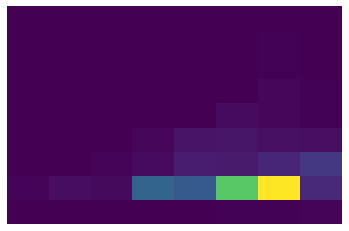

In [163]:
def save_spectrograms(label):
    # Use a small subset for debugging.
    for i, x in enumerate(X[y==label][:500]):
        frequencies, times, spectrogram = signal.spectrogram(x,2048)
        plt.pcolormesh(times, frequencies, spectrogram)
        plt.ylim(0, 72)
        plt.axis('off')
        
        plt.savefig('spec_data/' + str(label) + '/spec_' + str(i) + '.jpg')
        
save_spectrograms(0)
save_spectrograms(1)

In [164]:
datagen = ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory('spec_data/', class_mode='binary', batch_size=8, subset='training')
val_ds = datagen.flow_from_directory('spec_data/', class_mode='binary', batch_size=1, subset='validation')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


This needs revising. Currently it's a relatively deep network and effectively assumes that the images are actually 432x288x3. However, the images are much smaller in reality despite being saved at this resolution. Saving them in a smaller resolution e.g. 9x9 is the best bet. Then, a standard neural network can be used.

In [165]:
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    # Image augmentation block

    # Entry block
    x = inputs
    x = Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256]:#, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return Model(inputs, outputs)


model = make_model(input_shape=(432, 288, 3), num_classes=2)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 432, 288, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 432, 288, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 216, 144, 32) 896         rescaling_7[0][0]                
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 216, 144, 32) 128         conv2d_27[0][0]                  
____________________________________________________________________________________________

In [166]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [167]:
model.fit(
    train_ds, validation_data=val_ds, epochs=10, 
)

Epoch 1/10
100/100 [==============================] - 57s 554ms/step - loss: 0.7418 - accuracy: 0.4924 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 55s 550ms/step - loss: 0.7819 - accuracy: 0.5005 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 61s 613ms/step - loss: 0.7209 - accuracy: 0.5254 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 56s 557ms/step - loss: 0.7488 - accuracy: 0.5275 - val_loss: 0.6915 - val_accuracy: 0.5450
Epoch 5/10
100/100 [==============================] - 54s 542ms/step - loss: 0.7396 - accuracy: 0.5112 - val_loss: 0.8289 - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 54s 544ms/step - loss: 0.7452 - accuracy: 0.5213 - val_loss: 0.8900 - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 54s 540ms/step - loss: 0.7310 - accuracy: 0.5043 - val_loss: 1.2230 - val_ac

KeyboardInterrupt: 